NameError: name 'x' is not defined

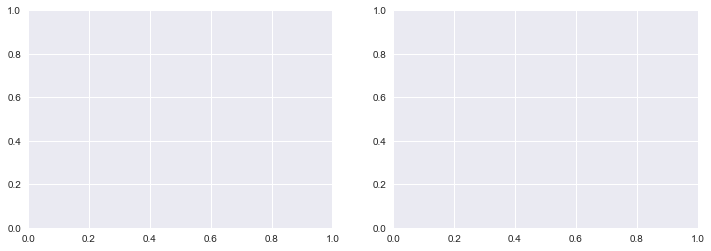

In [1]:
from pytorch_monitor import init_experiment, monitor_module


config = {
    'title':'Test Monitor',
    'log_dir':'test',
    'random_seed':42
}
writer, config = init_experiment(config)
config


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
sb.set()

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
sb.set()

class Model(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.encode = nn.Linear(1, hidden_dim)
        self.decode = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        h = F.tanh(self.encode(x))
        
        # Monitor h if we can
        if hasattr(self, 'monitor'):
            self.monitor('h', h, track_data=True, track_grad=True)
            
        yhat = self.decode(h)
        return yhat
    
# Setup the model and optimizer to have 10 hidden units
model = Model(10)
optimizer  = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)



# Enable monitoring
monitor_module(model, writer, 
               track_data=True,
               track_grad=True,
               track_update=True,
               track_update_ratio=True)

losses = []
nepochs = 3001
monitor_every = 500

# Plot the models initial predictions
_, (ax0, ax1) = plt.subplots(1,2, figsize=(12,4))
ax1.scatter(x.numpy(), y.numpy(), label='Truth', s=25, marker='^')

# Train the model for nepochs
for i in range(nepochs):
    
    # Save the computation graph for the first iteration
    if i == 0:
        writer.add_graph(model, x)
        
    # We only monitor network forward/backward passes 
    # occasionally for efficiency
    if i % monitor_every == 0:
        model.monitoring(True)
        print(i,'...', end=' ')
    else:
        model.monitoring(False)
        
    # Run the model, calculate loss, take a training step
    yhat = model(x)
    loss = ((yhat - y)**2).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Log loss values
    losses.append(loss.item())
    writer.add_scalar('train loss', loss.item(), i)
    
    # Plot predictions at intermediate steps
    if i % (nepochs//2) == 0:
        ax1.scatter(x.numpy(), yhat.detach().numpy(), label='Step {}'.format(i), s=20)

# Plot the learning curve and sample predictions
ax0.plot(list(range(len(losses))), losses)
ax0.set_title('Loss during training')
ax1.set_title('Predictions During Training')
_ = ax1.legend()

